In [2]:
from pylab import *
import numpy as np

# HW 10: A Model for the Dust Disk Continuum

The simplest model for a protoplanetary disk assumes an axisymmetric disk described by radial power-law profiles in:

1. Temperature: $T = T_0 (r/r_0)^{-q}$,  
and  
2. Surface Density: $\Sigma = \Sigma_0 (r/r_0)^{-p}$.  

We can use this to approximate the total continuum emission from a disk as the sum of the dust emission from a series of concentric annuli, each annulus will be at some radius $r$, have some width $\Delta r$, and based on the power-law profiles have some representative temperature $T$, and surface density $\Sigma$. 

## I. Building a Basic Slab Model
First, we are going to construct a general model for the dust continuum emission coming from a single annular slab of dust in the midplane. We are going to assume that the slab is in local thermodynamic equibilibrium and has a single temperature and surface density and that we are going to look at the whole system pole-on. 
For Class II systems, optically thin emission is typically assumed, so we'll need to use a dust opacity in order to calculate the optical depth. For now, we are going to assume a power law distribution for the opacity of the form:

$\kappa_{\lambda} = \kappa_0 (\lambda/\lambda_0)^{-\beta}$

with $\lambda_0 = 850 \mu m$, $\kappa_0  = 0.35 \mathrm{cm^2 \ g^{-1}}$, and $\beta = 1$. 

(This is a simplication for now, since we know that the dust opacity depends on the characteristic grain size and composition).


### part a.
We know that the intensity of a thermally emitting slab of dust at a given wavelength, $\lambda$, is given by:
$I_{\lambda} = B(\lambda,T) (1 - e^{-\tau_\lambda})$  

where for dust, $\tau = \Sigma_{d} \kappa_{\lambda}$.  Define a function to calculate the total intensity coming from a single slab given a surface density and a temperature for the slab for an array of wavelengths from 1 micron to 1 cm. 

In [3]:
kb = 1.3807e-16 #Boltzmann constant cgs
Gconv = 6.6743e-8 # cgs
sigsb = 5.671e-5 #Stefan Boltzmann constant
c = 2.99792458e10 # speed of light cgs
h = 6.6260755e-27 #planck constant cgs
mh = 1.67e-24 # mass of hydrogen cgs
pc = 3.086e18 #parsecs in cm
au = 1.49598e13 #au in cm

lam = np.logspace(-1,4,100) #logarithmically spaced array from 1 micron to 1 cm in microns.

def BB_lam(lam, T):
    """ planck function for a blackbody in terms of wavelength and temperature
    in ergs/s/str/cm^3 """
    lam_cgs = lam*1e-4 # microns to cm
    prefactor = 2. * h * c**2 / (lam_cgs**5)
    exponent = np.clip(h * c / (lam_cgs * kb * T),-600,600) #to avoid overflow issues
    return prefactor / (np.exp(exponent) - 1.)

def kappa_lam(lam,kappa_0 = 0.35, lam_0 = 850, beta = 1):
    """ returns an opacity in units of cm^2/g as a function of wavelength given some power-law """
    return kappa_0*(lam/lam_0)**(-beta)

def tau_lam(lam, sigma, kappa = kappa_lam):
    """ returns an optical depth given some wavelength, surface density, and opacity law"""
    return sigma * kappa(lam) 

def I_lam(lam,sigma,T):
    """ returns the total intensity as a function of wavelength 
    for a slab of surface density sigma and temperature T """
    return BB_lam(lam, T) * (1 - np.exp(-tau_lam(lam, sigma)))


### part b.
Now, in order to construct our SED, we want to calculate the total flux from a particular annulus, so we want to know the emitting area. 

Define functions to calculate the emitting area $dA$ of an annulus given it's $r$ and $\Delta r$ and then the total measured flux for the annulus received at some distance $d$ in parsecs.

In [4]:
def Area(r,dr):
    """ returns the area of an annulus in cm^2 centered on some radius r, 
    with width dr assuming radius in au """
    return np.pi * (((r + dr)*au)**2 - ((r - dr)*au)**2) 

def F_lam(lam,sigma,T,r,dr,d=1):
    """ returns the flux density as a function of wavelength for an annulus at a radius of
    r au from the central protostar with width dr viewed at some distance d"""
    F = I_lam(lam, sigma, T) * Area(r, dr)
    return F / (4 * np.pi * (d*pc)**2) 

### part c.
Now, look at how the expected flux from an annulus will vary according to its properties. Compared to the flux from the protostar, ```F_star``` shown below, let's plot our spectra in terms of $\lambda F_{\lambda}$. 

Assume a fiducial annular slab with $\Sigma_d = 1 \mathrm{g \ cm^{-2}}$ and $T = 20 K$ at $r = 5 \ \mathrm{au}$ with a width of $\Delta r = 1 \mathrm{au}$ at a distance of $d= 1 \ \mathrm{pc}$ from us.

Plot a fiducial slab as well as slabs changing one parameter at a time compared to the fiducial slab:
1. warmer (T = 100)
2. farther from the star (r = 100 au)

Based on our discussion of disk SED behavior in class, justify the behavior of slab model for each set of parameters. 
Hint: what do you expect from Wein's law and how we've defined flux?

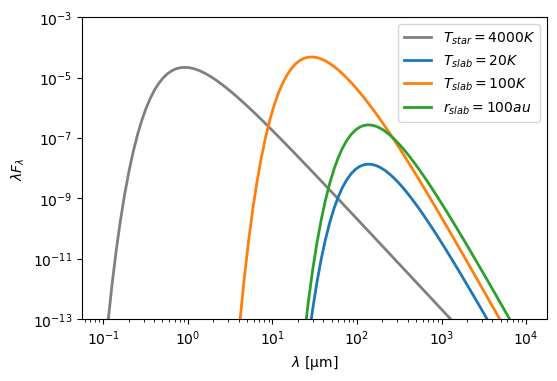

In [6]:
Rsun = 69.6e9 #radius of the sun in cm

def F_star(lam,Tstar=4000, Rstar = 2.*Rsun,d=1):
    d_cgs = d * pc
    area_star = pi * Rstar**2 
    return BB_lam(lam,Tstar)* area_star / (d_cgs**2)

slab_spec_fid = F_lam(lam, sigma=1, T=20, r=5, dr=1, d=1)
slab_spec_2 = F_lam(lam, sigma=1, T=100, r=5, dr=1, d=1)
slab_spec_3 = F_lam(lam, sigma=1, T=20, r=100, dr=1, d=1)

f,ax = subplots(1,dpi=100)
ax.loglog(lam, F_star(lam)*(lam*1e-4),lw=2,label=r'$T_{star} = 4000 K$',color='gray')
ax.loglog(lam, slab_spec_fid, lw=2, label=r'$T_{slab} = 20 K$')
ax.loglog(lam, slab_spec_2, lw=2, label=r'$T_{slab} = 100 K$')
ax.loglog(lam, slab_spec_3, lw=2, label=r'$r_{slab} = 100 au$')
ax.set_xlabel(r'$\lambda \ \mathrm{[\mu m]}$')
ax.set_ylabel(r'$\lambda F_\lambda $')
ax.set_ylim(1e-13,1e-3)
ax.legend()

### From Wien's law, a higher temperature should lead to peak emissions at shorter wavelengths. This holds true as the T=4000K model has the shortest wavelength at peak, and then the decreasing temperatures all increase in wavelength respectively. From our definition of flux, slab models with larger area will have a larger curve which is shown by the r=100au slab having a larger curve than the T=20K slab.

## II. Putting together a disk model
Now that we have constructed a model for thermal emission of an annulus, all that's left is to put this all together into an SED for the system.

We're going to assume a MMSN surface density profile ($\Sigma_{g,0} = 1700 \ \mathrm{ g \ cm^{-2}}$, $r_0 = 1 \ \mathrm{au}$, p = 1) for the gas and an ISM gas to dust ratio $\epsilon = \Sigma_g/\Sigma_d = 100$.

Next, we will assume that the temperature profile is that of a passively irradiated disk in thermal equilibrium, $q = 1/2$, you will need to calculate $T_0$ at $r_0 = 1 \ \mathrm{au}$ for a disk irradiated by a central protostar of $T_{star} = 4000 K$ and $R_{star} = 2 R_{\odot}$. 

### part a.
Define functions for the radial dust surface density profile and radial temperature profile. 

We will assume a disk with an inner edge of $r_{min} = 0.1 \mathrm{au}$ and $r_{max} = 100 \mathrm{au}$. 

Based on these calculations, what was the temperature at Earth's radius from the Sun during the protostellar phase? How does this compare to the current temperature of the Earth?

*Menu:*
Based on this model, what would be the total mass of solids contained within Earth's orbit in Earth masses? Is it enough to build the terrestrial planets?

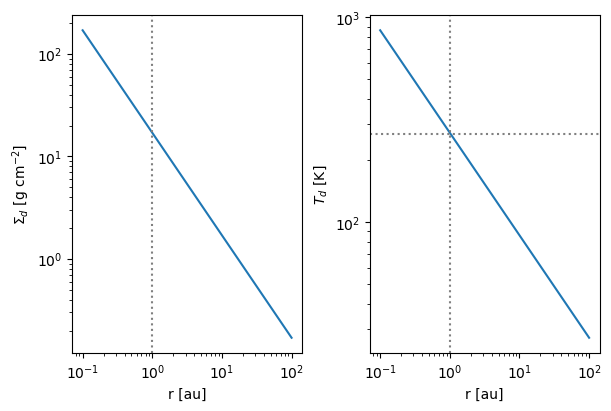

In [36]:
def sigma_d(r, sig0 = 1700, r0 = 1, g2d = 100, p = 1.0):
    return (sig0 / g2d) * (r/r0)**(-p)

def T_d(r, Tstar = 4000, Rstar = 2. * Rsun, r0 = 1, q = 0.5):
    T_0 = Tstar * np.sqrt(0.5 * Rstar/(r0*au))
    return T_0*(r/r0)**(-q)

r_d = np.logspace(-1,2,500)

f,ax = subplots(1,2,constrained_layout=True,sharex=True,dpi=100)
ax[0].loglog(r_d, sigma_d(r_d))
ax[1].loglog(r_d, T_d(r_d))
ax[0].set_xlabel('r [au]')
ax[1].set_xlabel('r [au]')
ax[0].set_ylabel(r'$\Sigma_d \ \mathrm{[g \ cm^{-2}]}$')
ax[1].set_ylabel(r'$T_d \ \mathrm{[K]}$')
ax[0].axvline(1,color='gray',ls='dotted')
ax[1].axvline(1,color='gray',ls='dotted')
ax[1].axhline(270,color='gray',ls='dotted')


The temperature at Earth was ~270K which is a bit cooler than the Earth today

### part b.
We've adopted a generalized form for the intensity, but often studies will assume that emission is optically thin. Now, we want to know how consistent this assumption is with our adopted opacity law for different wavelengths and locations in the disk.

We're going to construct a heat map for the optical depth across a parameter space of radii and wavelength for the surface density model adopted in part c. 

Below, I'm making a grid of points using ```np.meshgrid```. We can then use th
\is grid to find the optical depth at each radius and wavelength.

Based on where $\tau = 2/3$:
1. For which wavelengths is the disk optically thick at all radii?
2. At mm wavelengths (typical for ALMA), for what radii does the optically thin assumption still hold for this particular disk model?

Text(0, 0.5, '$\\log \\ \\lambda \\ \\mathrm{[\\mu m]}$')

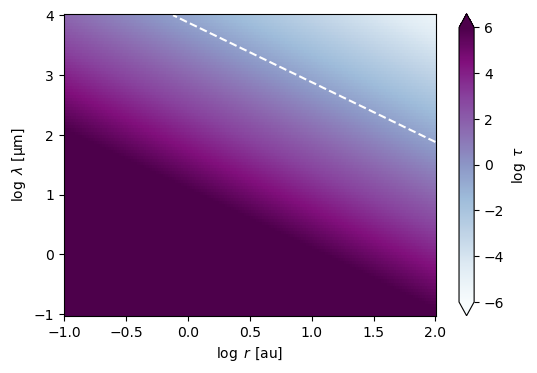

In [37]:
Rad, Lam = np.meshgrid(r_d,lam)

Sig = sigma_d(Rad)
Tau = tau_lam(Lam,Sig)

f,ax = subplots(1,dpi=100)
im = ax.pcolormesh(np.log10(Rad),np.log10(Lam),np.log(Tau),vmin=-6,vmax=6,cmap='BuPu')
colorbar(im,ax=ax,extend='both',label=r'$\log \ \tau$')
ax.contour(np.log10(Rad),np.log10(Lam),Tau,levels=[0,2/3],colors='white',linestyles='dashed')
ax.set_xlabel(r'$\log \ r \ \mathrm{[au]}$')
ax.set_ylabel(r'$\log \ \lambda \ \mathrm{[\mu m]}$')

### The disk is optically thick at all radii for wavelengths < ~10-15 $\mu m$
### At mm wavelengths, the optically thin assumption holds at about 10AU

### part c.
Now let's get to the main event. Based on a set of radial annuli, with surface densities and temperatures from our disk model above, we are going to plot the full SED for the disk and it's protostar as $\lambda F_{\lambda}$. 

Calculate the expected flux for each annulus, the total sum of which is the total disk SED. 

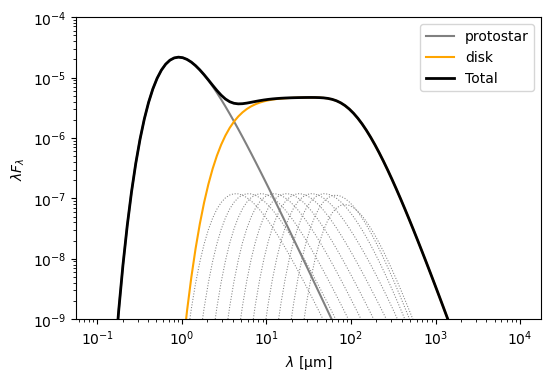

In [39]:
N_ann = 100
r_ann_edges = np.logspace(-1, 2, N_ann + 1)
r_ann = (r_ann_edges[1:] + r_ann_edges[:-1]) * (0.5)
dr_ann = np.diff(r_ann_edges)

F_tot = np.zeros_like(lam)

f,ax = subplots(1, dpi = 100)
protostar_sed = F_star(lam) * (lam*1e-4)

ax.loglog(lam, protostar_sed, lw=1.5, color='gray',label='protostar')

sigma = sigma_d(r_ann)
T = T_d(r_ann)
for i in range(len(r_ann)):
    F_ann = F_lam(lam, sigma=sigma[i], T=T[i],r=r_ann[i],dr=dr_ann[i],d=1)
    if i%10 == 0:
        ax.loglog(lam, F_ann*lam*1e-4, lw=0.75,color='gray',ls='dotted')
    F_tot += F_ann

disk_sed = F_tot * lam*1e-4

ax.loglog(lam, disk_sed, lw=1.5, color='orange', label='disk')
ax.loglog(lam, disk_sed + protostar_sed, lw=2, color='black',label='Total')
ax.set_ylim(1e-9,1e-4)
ax.set_xlabel(r'$\lambda \ \mathrm{[\mu m]}$')
ax.set_ylabel(r'$\lambda F_\lambda $')
ax.legend()

### Menu
Color-code the contributions in the plot above by their radius. From what parts of the disk are most of the mm contributions coming from? Which wavelengths are primarily optically thick contributions from? What is the influence of the opacity law on the behavior of the observed SED?